# Synthetic Opioid Prescribing Rates 2014

## About the Data and Hypothesis

The data is from 2014 for 25,000 Medicare prescribers across the United States
The dataset can be found [here](https://www.kaggle.com/apryor6/us-opiate-prescriptions).

After initial exploratory data analysis using [SQL queries](https://docs.google.com/document/d/1KjDykYBxfmbqQ_-_TimffpQlkY-Kl3PsDSO5Yc4aspk/edit?usp=sharing), there appears to be a slight correlation between the percentage of synthetic opioids prescribed and deaths as a proportion of a state's population. For example, North Dakota had the highest percentage of synthetic opioids and the lowest death rate. 

Because of this apparent correlation, it is important to know if the synthetic proportions are different across the country. Regions with lower prescribing proportions may want to urge their doctors to favor synthetic opioids over natural ones.

This project seeks to test the following null and alternate hypotheses: <br>
$H_0$ = $S_{(North East)}$ + $S_{(South)}$ + $S_{(Midwest)}$ + $S_{(West)}$ = $0$ <br>
    $H_A$ = $S_{(North East)}$ + $S_{(South)}$ + $S_{(Midwest)}$ + $S_{(West)}$ $\neq$ $0$ <br>
    Where $S_{(region)}$ is the average synthetic opioid percentage in each region. <br><br>
In other words, the null hypothesis is the means of the synthetic opioid percentage prescribed are not different between each region. The alternate hypothesis states that at least one region has a significantly different synthetic opioid percentage than the other regions.

## Setup

In [108]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import numpy as np

In [109]:
opioids = pd.read_csv('opioids_clean.csv')
op_agg = pd.read_csv('opioids_aggregated.csv')

In [110]:
opioids.head()

,NPI,State,total_synthetic,total_opioids,percent_synthetic,percent_deaths
0,1003002320,MS,0,36,0.000000,0.000112
1,1003008475,GA,0,0,0.000000,0.000121
2,1003009630,NY,0,91,0.000000,0.000117
3,1003016270,CT,53,236,0.224576,0.000173
4,1003024894,OH,16,89,0.179775,0.000237


**NPI** - the National Provider Identifier, a unique number given to each medical provider in the United States.<br>
**State** - the abbreviation of the state each provider practices in, includes only the 50 states, no territories.<br>
**total_synthetic** - the total number of Medicare claims that involved a synthetic opioid (Fentanyl or Tramadol HCl in this dataset)<br>
**total_opioids** - the total number of Medicare claims that involved an opioid regardless of natural or synthetic origin.<br>
**percent_synthetic** - total_synthetic / total_opioids <br>
**percent_deaths** - the percent of deaths caused by opioid overdose in the provider's state. This was found by dividing the number of deaths per state by the state's population from overdoses.csv. This is used instead of simply the Deaths column to account for the vastly differing populations of each state.
i.e. California has the highest number of deaths because California has the highest population; the proportion allows for better comparisons.

In [111]:
op_agg.head()

,State,percent_synthetic,percent_deaths,total_opioids_prescribed
0,FL,24.738616,0.013471,37645
1,TX,27.770840,0.009834,36249
2,CA,18.571208,0.011794,36056
3,PA,24.728483,0.021388,24818
4,OH,24.238647,0.023715,21975


**State** - the state's abbreviation <br>
**percent_synthetic** - the percent of total opioids that are synthetic per state <br>
**percent_deaths** - the percent of deaths due to opioid overdose per state <br>
**total_opioids_prescribed** - the total number of Medicare claims that involved an opioid per state <br>

In [112]:
# These are the regions defined by the US Census that will be used
northeast = ['PA', 'NY', 'VT', 'NH', 'ME', 'MA', 'RI', 'CT', 'NJ']
south = ['DE', 'MD', 'VA', 'WV', 'KY', 'NC', 'SC', 'TN', 'GA', 'AL', 'MS', 'AR', 'LA', 'TX', 'OK', 'FL']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
west = ['WA', 'OR', 'CA', 'ID', 'NV', 'AZ', 'UT', 'MT', 'WY', 'CO', 'NM', 'AK', 'HI']

In [113]:
# Add a region column to the dataframes to help with visualizations.
def add_region(row):
    if row['State'] in (northeast):
        return 'North East'
    elif row['State'] in (south):
        return 'South'
    elif row['State'] in (midwest):
        return'Midwest'
    else:
        return 'West'

opioids['region'] = opioids.apply(add_region, axis = 1)
op_agg['region'] = op_agg.apply(add_region, axis = 1)

In [114]:
#Split the data into four groups based on US Census region
ne = opioids[opioids['region'] == 'North East']
sth = opioids[opioids['region'] == 'South']
mw = opioids[opioids['region'] == 'Midwest']
wst = opioids[opioids['region'] == 'West']

#Sort alphabetically by region to ensure the order and color for each region is maintained across visualizations
op_agg = op_agg.sort_values(by = ['region'], ascending = True)
opioids = opioids.sort_values(by = ['region'], ascending = True)

In [115]:
#Check to see how big each group is. They need to be roughly the same size for stats.
print(ne.shape[0],
sth.shape[0],
mw.shape[0],
wst.shape[0])

2749 5318 3247 3192


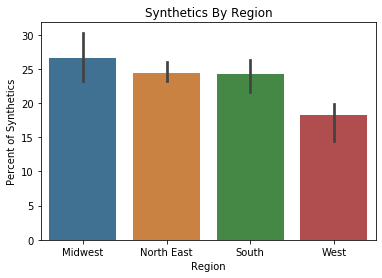

In [174]:
synthetics_by_region = sns.barplot(x="region", y="percent_synthetic", estimator = np.median, data=op_agg, ci = 90)
synthetics_by_region.set(xlabel = 'Region', ylabel = 'Percent of Synthetics', title = 'Synthetics By Region')
plt.show()

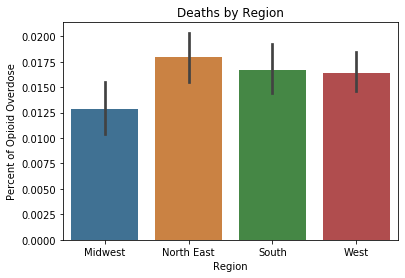

In [175]:
deaths_by_region = sns.barplot(x="region", y="percent_deaths", data=op_agg, ci = 90)
deaths_by_region.set(xlabel = 'Region', ylabel = 'Percent of Opioid Overdose', title = 'Deaths by Region')
plt.show()

The Midwest has the highest synthetic prescribing percentage, but the lowest death percentage. Is there a correlation between the percent of synthetics prescribed and deaths?

In [118]:
# See how the data are correlated by region. Percent synthetic is moderately negatively correlated to percent deaths
stats.pearsonr(op_agg['percent_synthetic'], op_agg['percent_deaths'])

(-0.3572851757614184, 0.010859902186219118)

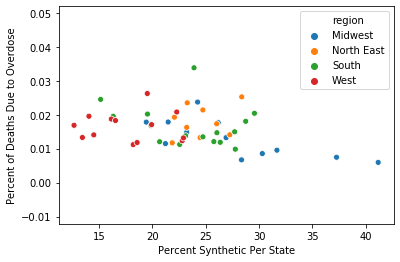

In [119]:
# Visualize the correlation between synthetics and deaths. Note how each region is grouped together, further supporting
#the alternate hypothesis. 
scatter_by_region = sns.scatterplot('percent_synthetic', 'percent_deaths', hue = 'region', data = op_agg)

scatter_by_region.set(xlabel = 'Percent Synthetic Per State', ylabel = 'Percent of Deaths Due to Overdose')
plt.show()

Nationwide, there appears to be a moderate negative correlation between percent of synthetics and deaths, but is the rate at which regions prescribe synthetic opioids actually different?

To answer this, the data will be split into four regions (based on US Census regions) and analyzed using either a one-way ANOVA test if the data are normally distributed or a Kruskal-Wallis test if the data are not normally distributed. 

It is important to note that this assumes the percent of synthetic opioids prescribed of one state is independent of the percent of any other state.

## Check normality of data

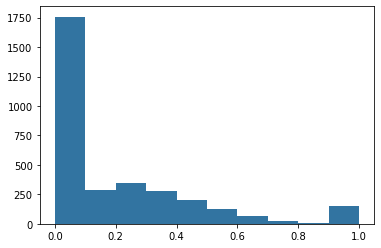

DescribeResult(nobs=3247, minmax=(0.0, 1.0), mean=0.1884765676678678, variance=0.06993903015752867, skewness=1.585144449113957, kurtosis=2.0068667807460363)

In [150]:
plt.hist(mw['percent_synthetic'], color = "#3274a1")
plt.show()
stats.describe(mw['percent_synthetic'])

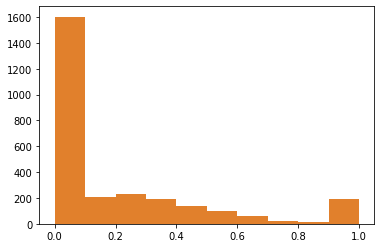

DescribeResult(nobs=2749, minmax=(0.0, 1.0), mean=0.19310359102655486, variance=0.08461726789291404, skewness=1.5975605273515787, kurtosis=1.6290273389460843)

In [145]:
plt.hist(ne['percent_synthetic'], color = "#e1802c")
plt.show()
stats.describe(ne['percent_synthetic'])

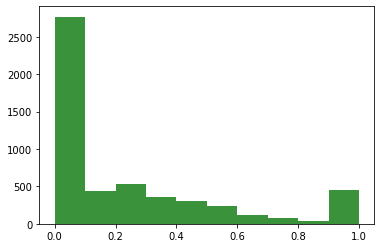

DescribeResult(nobs=5318, minmax=(0.0, 1.0), mean=0.22772362596437515, variance=0.09552952134927256, skewness=1.3615257498769793, kurtosis=0.7858132916528153)

In [146]:
plt.hist(sth['percent_synthetic'], color = '#3a923a')
plt.show()
stats.describe(sth['percent_synthetic'])

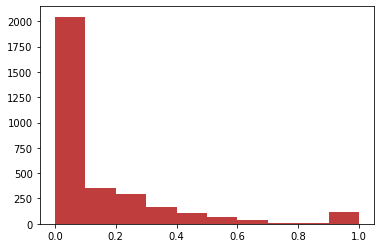

DescribeResult(nobs=3192, minmax=(0.0, 1.0), mean=0.13247356662881174, variance=0.052905675190742234, skewness=2.297190690335941, kurtosis=5.286746633760908)

In [149]:
plt.hist(wst['percent_synthetic'], color = "#c03d3e")
plt.show()
stats.describe(wst['percent_synthetic'])

The data *is not* normal enough to use parametric tests, so a Kruskal-Wallis test will be performed.

## The statistical tests

In [124]:
stats.kruskal(ne['percent_synthetic'], sth['percent_synthetic'], mw['percent_synthetic'], 
               wst['percent_synthetic'])

KruskalResult(statistic=183.72858867296281, pvalue=1.381074470372199e-39)

In [125]:
_, p1 = stats.kruskal(ne['percent_synthetic'], sth['percent_synthetic'])
_, p2 = stats.kruskal(ne['percent_synthetic'], mw['percent_synthetic'])
_, p3 = stats.kruskal(ne['percent_synthetic'], wst['percent_synthetic'])
_, p4 = stats.kruskal(sth['percent_synthetic'], mw['percent_synthetic'])
_, p5 = stats.kruskal(sth['percent_synthetic'], wst['percent_synthetic'])
_, p6 = stats.kruskal(mw['percent_synthetic'], wst['percent_synthetic'])

p_values = [p1, p2, p3, p4, p5, p6]
p_values

[2.4670419208149387e-08,
 0.07773061494226854,
 4.976756025155124e-10,
 5.5872960943026794e-05,
 7.379237961022348e-41,
 3.726779176901295e-19]

Just based on these p values, it appears there is a significant difference between most groups; however, when multiple statistical tests are done, there is an increased chance of rejecting the null when there is no actual difference.

In [126]:
multipletests(p_values, alpha = 0.05)

(array([ True, False,  True,  True,  True,  True]),
 array([7.40112560e-08, 7.77306149e-02, 1.99070227e-09, 1.11742800e-04,
        0.00000000e+00, 0.00000000e+00]),
 0.008512444610847103,
 0.008333333333333333)

All but one null hypotheses are rejected. Nearly each region of the United States has a significantly different prescribing rate than the others, but there is *not* a significant difference between the North East and the Midwest as seen in the point plot below:

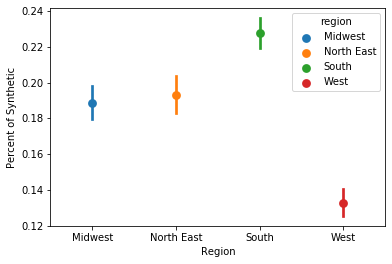

In [128]:
point = sns.pointplot(x = 'region', y = 'percent_synthetic', hue= 'region', data = opioids, join = False)
point.set(xlabel = 'Region', ylabel = 'Percent of Synthetic')
plt.show()

In [164]:
def cles_ind(x1, x2):
    """Calc common language effect size
    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.
    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361
    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

In [165]:
cles_ind(ne['percent_synthetic'], sth['percent_synthetic'])

0.3966711680585138

In [166]:
cles_ind(ne['percent_synthetic'], wst['percent_synthetic'])

0.37548832977314145

In [167]:
cles_ind(wst['percent_synthetic'], sth['percent_synthetic'])

0.4332343881516503

In [168]:
cles_ind(mw['percent_synthetic'], sth['percent_synthetic'])

0.39619103953740736

In [169]:
cles_ind(mw['percent_synthetic'], wst['percent_synthetic'])

0.4041572401900964

While the differences between these regions is significant, the effect size is less than 50% for each pairing.

## Conclusion

In the regions with lower synthetic opioid percentages, doctors may be interested to know that raising that percentage might decrease overdose deaths. It is important to note that correlation does not mean causation. It cannot be said with certainty that prescribing a higher percentage of synthetic opioids causes fewer deaths. The Midwest and North East do not have significantly different synthetic percentages, but do have greatly different death rates. At the same time, the South and the West do have significantly different prescribing rates, but do not have different death rates. It is possible that the overdose death rates are  related to regional differences in illicit use of opioids, income, and support programs offered. 

It is also important to note that the "Deaths" column in the tables refers to the total number of deaths in each state due to *any* opioid overdose, not just synthetics. Breaking these deaths into subcategories based on the type of opioid that caused the death may prove insighful.

Since all the prescriptions in this dataset come from Medicare, it may be interesting to see how synthetic percentages differ across insurance companies. Each company has its own formulary (a list of drugs it will cover), and regions where a certain company is dominant may have even larger differences.

Additonaly, if further data was collected, recording deaths on a per-doctor basis rather than per-state would allow for better statistics due to larger sample sizes.